In [1]:
# Uncomment and run if do not have the dependencies
# !pip install torchsummary

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from torchvision.models import vgg11_bn
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.ion()   # interactive mode

# Seed for consistent result
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)
torch.backends.cudnn.deterministic = True

# Log file
f = open("./logs/{}.txt".format(datetime.now().strftime("%Y-%m-%d_%H-%M-%S")), "a")

In [2]:
class TrainingMode:
    DEFAULT = "default"
    CLASSES_A = "classes A"
    CLASSES_B = "classes B"

In [3]:
def load_model_dict(path):
    return torch.load(path)

def save_model_dict(model_dict, path):
    torch.save(model_dict, path)

def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def get_base_path(training_mode):
    return "./models/base {}".format(training_mode)

def get_final_path(base_training_mode, final_training_mode, frozen_layer_count):
    return "./models/final {} {} {}".format(base_training_mode, frozen_layer_count, final_training_mode)

def pnw(*args):
    print(*args)
    print(*args, file=f)

In [4]:
# Datasets and loader
# normalize_transform = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet
normalize_transform = transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]) # CIFAR-100

image_root_path = './data'
image_datasets = datasets.CIFAR10(
    image_root_path, 
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize_transform
    ])
)
test_datasets = datasets.CIFAR10(
    image_root_path, 
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize_transform
    ])
)
# print(len(image_datasets))
# print(len(test_datasets))

validation_ratio = 0.2
datasets_size = len(image_datasets)
indices = list(range(datasets_size))
np.random.shuffle(indices)
split = int(np.floor(validation_ratio * datasets_size))
train_indices, validation_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

train_data_loader = torch.utils.data.DataLoader(
    image_datasets,
#     batch_size=5, # For visualization
    batch_size=100, # For real training
    num_workers=1,
    sampler=train_sampler
)

validation_data_loader = torch.utils.data.DataLoader(
    image_datasets,
#     batch_size=5, # For visualization
    batch_size=100, # For real training
    num_workers=1,
    sampler=validation_sampler
)

test_data_loader = torch.utils.data.DataLoader(
    test_datasets,
    batch_size=100, # For real training
    num_workers=1
)

train_dataset_size = datasets_size * (1 - validation_ratio)
validation_dataset_size = datasets_size * validation_ratio

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Random Split

# Change seed for different split
np.random.seed(100)

classes = image_datasets.classes
indices = list(range(len(classes)))
np.random.shuffle(indices)
split = int(np.floor(len(classes) / 2))
classes_A = np.random.choice(len(classes), int(len(classes) / 2), replace=False)
classes_B = np.setdiff1d(np.arange(len(classes)), classes_A)

pnw("Classes A\n{}\n".format(sorted(np.array(classes)[classes_A])))
pnw("Classes B\n{}\n".format(sorted(np.array(classes)[classes_B])))

Classes A
['cat', 'deer', 'dog', 'horse', 'ship']

Classes B
['airplane', 'automobile', 'bird', 'frog', 'truck']



In [6]:
# Uncomment for custom split

# a1 = ['bird', 'cat', 'deer']
# a2 = ['frog', 'horse', 'dog']
# v = ['airplane', 'automobile', 'truck', 'ship']
# classes_A_text = ['airplane', 'automobile', 'truck', 'ship']
# classes_B_text = ['bird', 'cat', 'deer']

# # These below are indices, do not change the code
# classes_A = [classes.index(text) for text in classes_A_text]
# classes_B = [classes.index(text) for text in classes_B_text]

# pnw("Classes A\n{}\n".format(classes_A_text))
# pnw("Classes B\n{}\n".format(classes_B_text))

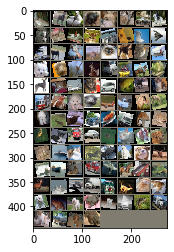

In [7]:
def show_image(image, title=None):
    mean = normalize_transform.mean
    std = normalize_transform.std
    image = image.numpy().transpose((1, 2, 0)) * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    
    if title is not None:
        plt.title(title)
    
inputs, classes = next(iter(train_data_loader))
show_image(torchvision.utils.make_grid(inputs))

In [8]:
def train(model, criterion, optimizer, scheduler, epoch_count, training_mode, description=""):
    pnw("Current traning mode:", training_mode)
    
    start_time = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    for e in range(epoch_count):
        pnw("[{}/{}] {}".format(e + 1, epoch_count, description))
        pnw("=" * 30)
        
        # Go through train dataset and validation dataset each epoch
        for data_loader in [train_data_loader, validation_data_loader]:
            is_training = data_loader == train_data_loader
            pnw("Training..." if is_training else "Validating...")
            
            # Change model mode
            model.train() if is_training else model.eval()
            
            loss = 0
            correct_count = 0
            
            total_size = 0
            
            # Iterate over images
            for images, labels in data_loader:
                if training_mode == TrainingMode.CLASSES_A:
                    idx = np.isin(labels, classes_A)
                    images = images[idx]
                    labels = labels[idx]
                elif training_mode == TrainingMode.CLASSES_B:
                    idx = np.isin(labels, classes_B)
                    images = images[idx]
                    labels = labels[idx]
                    
                # Skip as this batch is for another class
                if len(images) == 0:
                    continue
                
                total_size += len(images)
                
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(is_training):
                    outputs = model(images)
                    _, predictions = outputs.max(1)
                    loss = criterion(outputs, labels)

                    # Backward
                    if is_training:
                        loss.backward()
                        optimizer.step()

                loss += len(images) * loss.item() 
                correct_count += torch.sum(predictions == labels.data)

            if is_training and scheduler is not None:
                scheduler.step()
            
            pnw("Total size: ", total_size)
            e_loss = loss / total_size
            e_accuracy = correct_count.double() / total_size
            
            pnw("Loss: {:.4f} accuracy: {:.4f}\n".format(e_loss, e_accuracy))
            
            # Backup best model
            if not is_training and best_accuracy < e_accuracy:
                best_accuracy = e_accuracy
                best_weights = copy.deepcopy(model.state_dict())
        pnw()
    
    duration = time.time() - start_time
    pnw("Training completed in {:.0f}m {:.0f}s".format(duration // 60, duration % 60))
    pnw("Best accuracy: {:4f}".format(best_accuracy))
    
    model.load_state_dict(best_weights)
    return model

In [9]:
class VGG11_BN_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = self.make_feature_layers([
            64,
            'maxpool',
            128,
            'maxpool',
            256,
            256,
            'maxpool',
            512,
            512,
            'maxpool',
            512,
            512,
            'maxpool'
        ])

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10)
        )
        
    def make_feature_layers(self, configs):
        feature_layers = []
        
        input_channel = 3
        for c in configs:
            if c == 'maxpool':
                feature_layers.append(
                    nn.MaxPool2d(kernel_size=2, stride=2)
                )
                continue
            
            feature_layers += [
                nn.Conv2d(input_channel, c, kernel_size=3, padding=1),
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True)
            ]
            
            input_channel = c
        return nn.Sequential(*feature_layers)

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
    
        return output

In [10]:
# Figure out parameters different layers
vgg = VGG11_BN_CIFAR()
vgg.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

vgg = vgg.to(device)

# Show readable model summary
# summary(vgg, (3, 64, 64)) 

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [11]:
# Baseline
# base_training_mode = TrainingMode.DEFAULT
# final_training_mode = None

# BaseA
# base_training_mode = TrainingMode.CLASSES_A
# final_training_mode = None

# BaseB
# base_training_mode = TrainingMode.CLASSES_B
# final_training_mode = None

# AnA
# base_training_mode = TrainingMode.CLASSES_A
# final_training_mode = TrainingMode.CLASSES_A

# BnB
# base_training_mode = TrainingMode.CLASSES_B
# final_training_mode = TrainingMode.CLASSES_B

# AnB
base_training_mode = TrainingMode.CLASSES_A
final_training_mode = TrainingMode.CLASSES_B

# BnA
# base_training_mode = TrainingMode.CLASSES_B
# final_training_mode = TrainingMode.CLASSES_A

# skip_base = False
skip_base = True
# frozen_layer_counts = range(1, 11)
# frozen_layer_counts = [2,3,5,6,8,9]
frozen_layer_counts = [1,4,7,10]

In [12]:
if not skip_base:
    base_vgg = train(vgg, criterion, optimizer, scheduler, 200, base_training_mode, "base {}".format(base_training_mode))
    save_model_dict(base_vgg.state_dict(), get_base_path(base_training_mode))

In [ ]:
if final_training_mode is not None:
    for frozen_layer_count in frozen_layer_counts:
        pnw("Frozen layer count (n): ", frozen_layer_count)
        
        prefixes = []
        current_prefix = ""
        vgg = VGG11_BN_CIFAR()

        for name, param in vgg.named_parameters():
            prefix = ".".join(name.split(".")[:2])
            if prefix != current_prefix:
                prefixes.append(prefix)
            current_prefix = prefix

        # Freeze the layers at the front
        # Remaining layers at the back should reinit by random weights
        frozen_prefixes = prefixes[:frozen_layer_count]
        init_prefixes = prefixes[frozen_layer_count:]


        # Load state_dict from base model and remove those unfrozen layers one
        model_dict = load_model_dict(get_base_path(base_training_mode))
        to_remove_keys = []
        for key in model_dict.keys():
            prefix = ".".join(name.split(".")[:2])
            if prefix in init_prefixes:
                to_remove_keys.append(key)

        for key in model_dict:
            prefix = ".".join(name.split(".")[:2])
            if prefix in to_remove_keys:
                model_dict.pop(key)

        vgg.load_state_dict(model_dict, strict=False)
        for name, param in vgg.named_parameters():
            prefix = ".".join(name.split(".")[:2])
            param.requires_grad = prefix not in frozen_prefixes

        vgg.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(vgg.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)

        final_vgg = train(vgg, criterion, optimizer, scheduler, 200, final_training_mode, "n={}".format(frozen_layer_count))
        save_model_dict(final_vgg.state_dict(), get_final_path(base_training_mode, final_training_mode, frozen_layer_count))

Frozen layer count (n):  1
Current traning mode: classes B
[1/200] n=1
Training...
Total size:  20001
Loss: 0.0021 accuracy: 0.6226

Validating...
Total size:  4999
Loss: 0.0065 accuracy: 0.6915


[2/200] n=1
Training...
Total size:  20001
Loss: 0.0019 accuracy: 0.7367

Validating...
Total size:  4999
Loss: 0.0055 accuracy: 0.7005


[3/200] n=1
Training...
Total size:  20001
Loss: 0.0024 accuracy: 0.7696

Validating...
Total size:  4999
Loss: 0.0056 accuracy: 0.7954


[4/200] n=1
Training...
Total size:  20001
Loss: 0.0009 accuracy: 0.7792

Validating...
Total size:  4999
Loss: 0.0077 accuracy: 0.7804


[5/200] n=1
Training...
Total size:  20001
Loss: 0.0014 accuracy: 0.7877

Validating...
Total size:  4999
Loss: 0.0059 accuracy: 0.8174


[6/200] n=1
Training...
Total size:  20001
Loss: 0.0012 accuracy: 0.7995

Validating...
Total size:  4999
Loss: 0.0053 accuracy: 0.7812


[7/200] n=1
Training...
Total size:  20001
Loss: 0.0012 accuracy: 0.8010

Validating...
Total size:  4999
Loss: 0

In [ ]:
def test(final_vgg, training_mode):
    final_vgg.to(device)
    final_vgg.eval()

    top1_correct_count = 0.0
    top5_correct_count = 0.0

    test_size = 0
    for i, (images, labels) in enumerate(test_data_loader):
        if training_mode == TrainingMode.CLASSES_A:
            idx = np.isin(labels, classes_A)
            images = images[idx]
            labels = labels[idx]
        elif training_mode == TrainingMode.CLASSES_B:
            idx = np.isin(labels, classes_B)
            images = images[idx]
            labels = labels[idx]

        # Skip as this batch is for another class
        if len(images) == 0:
            continue

        test_size += len(images)

        images = images.to(device)
        labels = labels.to(device)
        output = final_vgg(images)
        _, predictions = output.topk(5, 1, largest=True, sorted=True)

        labels = labels.view(labels.size(0), -1).expand_as(predictions)
        accurate_predictions = predictions.eq(labels).float()

        top1_correct_count += accurate_predictions[:, :1].sum()
        top5_correct_count += accurate_predictions[:, :5].sum()
    
    pnw("Test Size: {}".format(test_size))
    pnw("Top 1 error: {0:.2%}".format(1 - top1_correct_count.item() / test_size))
    pnw("Top 5 error: {0:.2%}".format(1 - top5_correct_count.item() / test_size))
    pnw("Accuracy: {0:.2%}".format(top1_correct_count.item() / test_size))
    pnw("")

if final_training_mode is None:
    if base_training_mode == TrainingMode.DEFAULT:
        pnw("Testing Default")
    elif base_training_mode == TrainingMode.CLASSES_A:
        pnw("Testing Base A")
    elif base_training_mode == TrainingMode.CLASSES_B:
        pnw("Testing Base B")
    final_vgg = VGG11_BN_CIFAR()
    final_vgg.load_state_dict(load_model_dict(get_base_path(base_training_mode)))
    test(final_vgg, base_training_mode)
else: 
    for frozen_layer_count in frozen_layer_counts:
        pnw("Testing {} with n={}".format(final_training_mode, frozen_layer_count))
        final_vgg = VGG11_BN_CIFAR()
        final_vgg.load_state_dict(load_model_dict(get_final_path(base_training_mode, final_training_mode, frozen_layer_count)))
        test(final_vgg, final_training_mode)

f.close()

In [ ]:
from IPython.display import Audio, display

display(Audio("https://www.soundjay.com/misc/bell-ringing-04.mp3", autoplay=True))
display(Audio("https://www.soundjay.com/misc/bell-ringing-04.mp3", autoplay=True))